# FIGS 2H & 3B

*Marcos Martinez Jimenez*

---

Script used to obtain figures 2H and 3B from Networld's PNAS. Basic check that the model retains desirable properties after being modified.

**Input**: processed networld simulation data

***Module Import***

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import entropy

from networld_utils import *
import plotly.express as px


## Unique Model

***Data loading***

In [4]:
# Path where all SRC files are included
data_path = '../data/Networld_N200_TMax10000/'

nt_list = []
for data_file in os.listdir(data_path):
    info = data_file[:-4].split('_')
    if info[0] != 'SRC':
        continue
    beta = info[3][4:]
    rep = info[5][3:]
    data_file = data_path + data_file
    src = pd.read_csv(data_file)
    src['beta'] = float(beta)
    src['rep'] = int(rep)
    nt_list.append(src)


For this figures the abundance of networks for each $\beta$ is enough

In [5]:
exp_data = pd.concat(nt_list, axis=0)
exp_data = exp_data.sort_values(by=['beta', 'rep', 'NRed'])
exp_data = exp_data.groupby(['beta', 'NRed'])['NRep'].sum().reset_index()
exp_data['NRep'] = exp_data['NRep'] / \
    exp_data.groupby('beta')['NRep'].transform(sum)
exp_data.head()


,beta,NRed,NRep
0,0.001000,1,0.990566
1,0.001000,2,0.009425
2,0.001000,30,0.000009
3,0.001585,1,0.985465
4,0.001585,2,0.014514


### Compute metrics

***# Configurations***

In [6]:
# Number of different network identifiers by beta
num_configs = exp_data.groupby('beta')['NRed'].nunique().reset_index()
num_configs.head()


,beta,NRed
0,0.001000,3
1,0.001585,4
2,0.002512,5
3,0.003981,5
4,0.006310,6


***Normalized H***

In [7]:
normH = exp_data.groupby('beta')['NRep'].aggregate(entropy).reset_index()
normH['NRep'] = normH['NRep'] / np.log2(num_configs['NRed'])
# For beta=0 only one network -> NA value, but should be a 0
normH = normH.fillna(0)
normH.head()


,beta,NRep
0,0.001000,0.033724
1,0.001585,0.038044
2,0.002512,0.047038
3,0.003981,0.065680
4,0.006310,0.080811


### Transition Limits

Function to inspect the graphs and select adecuate transition limits

In [8]:
def pnas_2h_3b(num_configs, normH, logx=False, xlims=[0, 3]):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 3))

    ax1.plot(num_configs['beta'], num_configs['NRed'], 'o')
    ax1.set_title('2H')
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel('# Configurations')
    ax1.set_yscale('log')
    if logx:
        ax1.set_xscale('log')
    ax1.set_xlim(xlims[0], xlims[1])
    ax1.grid(which='both', axis='x')
    ax1.grid(which='major', axis='y')

    ax2.plot(normH['beta'], normH['NRep'], 'o')
    ax2.set_title('3B')
    ax2.set_xlabel(r'$\beta$')
    ax2.set_ylabel('Normalized H')
    if logx:
        ax2.set_xscale('log')
    ax2.set_xlim(xlims[0], xlims[1])
    ax2.grid(which='both', axis='x')
    ax2.grid(which='major', axis='y')

    fig.tight_layout()
    fig.show()


/tmp/ipykernel_11524/3651955432.py:11: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(xlims[0], xlims[1])
/tmp/ipykernel_11524/3651955432.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(xlims[0], xlims[1])
/tmp/ipykernel_11524/3651955432.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


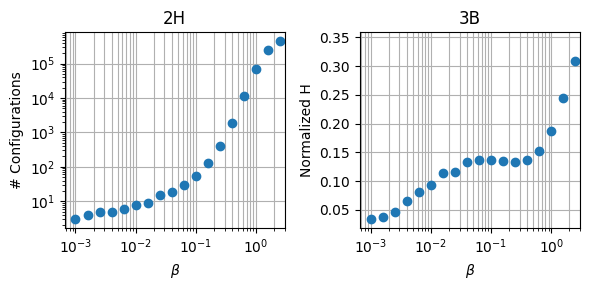

In [9]:
pnas_2h_3b(num_configs, normH, logx=True)


***Transition Bounds***

In [27]:
# 1st value is critic beta and 2nd is the change of behaviour
# caused by network colapse and node limitation
beta_lims = (-1.1, -0.2)

In [28]:
logbeta = np.log10(num_configs['beta'])

In [29]:
pre_idx = (logbeta < beta_lims[0])
pos_idx = (logbeta >= beta_lims[0]) \
    & (logbeta < beta_lims[1])

p_nc_pre = np.polyfit(logbeta[pre_idx],
                      np.log(num_configs.loc[pre_idx, 'NRed']), 1)
p_nc_pos = np.polyfit(logbeta[pos_idx],
                      np.log(num_configs.loc[pos_idx, 'NRed']), 1)
p_nH_pre = np.polyfit(logbeta[pre_idx],
                      normH.loc[pre_idx, 'NRep'], 1)
p_nH_pos = np.polyfit(logbeta[pos_idx],
                      normH.loc[pos_idx, 'NRep'], 1)


In [30]:
pre_beta_lr = np.array([-3, beta_lims[0]+0.1])
pos_beta_lr = np.array([beta_lims[0]-0.1, beta_lims[1]])

pre_nc_lr = np.exp(pre_beta_lr * p_nc_pre[0] + p_nc_pre[1])
pos_nc_lr = np.exp(pos_beta_lr * p_nc_pos[0] + p_nc_pos[1])

pre_nH_lr = pre_beta_lr * p_nH_pre[0] + p_nH_pre[1]
pos_nH_lr = pos_beta_lr * p_nH_pos[0] + p_nH_pos[1]

nc_lr_intersect = (p_nc_pre[1] - p_nc_pos[1]) / (p_nc_pos[0] - p_nc_pre[0])
nH_lr_intersect = (p_nH_pre[1] - p_nH_pos[1]) / (p_nH_pos[0] - p_nH_pre[0])


### Final Graph

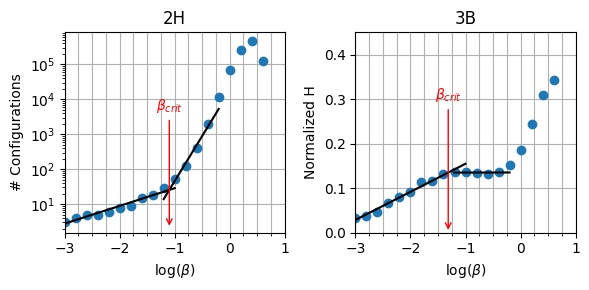

In [31]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 3))

ax1.plot(logbeta, num_configs['NRed'], 'o')
ax1.plot(pre_beta_lr, pre_nc_lr, '-', color='black')
ax1.plot(pos_beta_lr, pos_nc_lr, '-', color='black')
ax1.annotate(r'$\beta_{crit}$', xy=(nc_lr_intersect, 2),
             xytext=(nc_lr_intersect,5000),
             horizontalalignment='center',
             color='red',
             arrowprops=dict(color='red', arrowstyle='->', lw=1))
ax1.set_title('2H')
ax1.set_xlabel(r'log($\beta$)')
ax1.set_ylabel('# Configurations')
ax1.set_yscale('log')
ax1.set_xlim(-3, 1)
ax1.set_xticks(np.arange(-3, 1, 0.25), minor=True)
ax1.grid(which='both', axis='x')
ax1.grid(which='major', axis='y')

ax2.plot(logbeta, normH['NRep'], 'o')
ax2.plot(pre_beta_lr, pre_nH_lr, '-', color='black')
ax2.plot(pos_beta_lr, pos_nH_lr, '-', color='black')
ax2.annotate(r'$\beta_{crit}$', xy=(nH_lr_intersect, 0),
            xytext=(nH_lr_intersect, 0.3),
            horizontalalignment='center',
            color='red',
            arrowprops=dict(color='red', arrowstyle='->', lw=1))
ax2.set_title('3B')
ax2.set_xlabel(r'log($\beta$)')
ax2.set_ylabel('Normalized H')
ax2.set_xlim(-3, 1)
ax2.set_ylim(0, 0.45)
ax2.set_xticks(np.arange(-3, 1, 0.25), minor=True)
ax2.grid(which='both', axis='x')
ax2.grid(which='major', axis='y')

fig.tight_layout()


### Mean Network Size

Can be used to identify the range of beta in which different models would be consistent. 

For instance, Networld's crit point tends to be around 30-35 networks for N=40

In [ ]:
tmp_data = pd.concat(nt_list, axis=0)
tmp_data = tmp_data.sort_values(by=['beta', 'rep', 'NRed'])
tmp_data = tmp_data.groupby(['beta', 'rep', 't'])['NRep'].sum().reset_index()
tmp_data = tmp_data.groupby(['beta'])['NRep'].mean().reset_index()
tmp_data.head(5)


<Figure size 600x400 with 0 Axes>

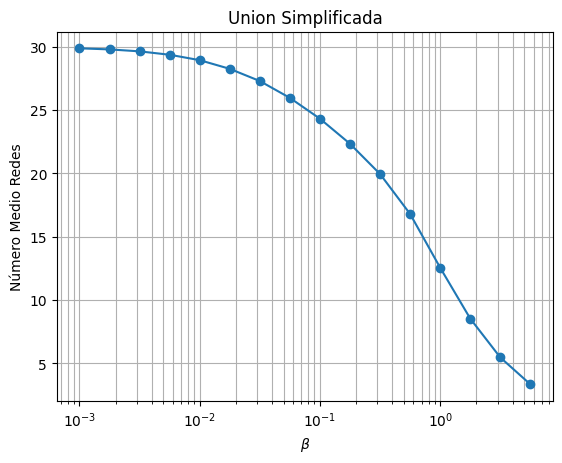

In [ ]:
plt.figure(figsize=(6, 4))
tmp_data.plot(x='beta', y='NRep', style='-o', legend=False)
plt.xlabel(r'$\beta$')
plt.ylabel('Número Medio Redes')
plt.xscale('log')
plt.title('Union Simplificada')
# plt.xticks(np.arange(01.1,0.05))
plt.grid(which='both')i


## 2H & 3B Collapse

In [70]:
paths = ['Networld_N20_TMax10000_Kinetics_Binomial_Unscaled/',
        'Networld_N30_TMax10000_Kinetics_Binomial_K5/',
        'Networld_N40_TMax10000_Kinetics_Binomial_Unscaled/',
        'Networld_N60_TMax5000_Kinetics_Binomial_Unscaled/',
        'Networld_N120_TMax5000_Kinetics_Binomial_Unscaled/',
        'Networld_N240_TMax5000_Kinetics_Binomial_Unscaled/']

plot_data = {}
for path in paths:

    N = path.split('_')[1][1:]
    data_path = '../data/' + path

    nt_list = []
    for data_file in os.listdir(data_path):
        info = data_file[:-4].split('_')
        if info[0] != 'SRC':
            continue
        beta = info[2][4:]
        rep = info[4][3:]
        data_file = data_path + data_file
        src = load_src_networld(data_file)
        src['beta'] = float(beta)
        src['rep'] = int(rep)
        nt_list.append(src)

    exp_data = pd.concat(nt_list, axis=0)
    exp_data = exp_data.sort_values(by=['beta', 'rep', 'NRed'])
    exp_data = exp_data.groupby(['beta', 'NRed'])['NRep'].sum().reset_index()
    exp_data['NRep'] = exp_data['NRep'] / \
        exp_data.groupby('beta')['NRep'].transform(sum)

    plot_dat = exp_data.groupby('beta')['NRed'].nunique().reset_index()
    plot_dat.rename(columns={'NRed': '# Configs'}, inplace=True)
    plot_dat['entropy'] = exp_data.groupby('beta')['NRep'].aggregate(entropy).reset_index(drop=True)
    plot_dat['entropy'] = plot_dat['entropy'] / np.log2(plot_dat['# Configs'])

    tmp_data = pd.concat(nt_list, axis=0)
    tmp_data = tmp_data.sort_values(by=['beta', 'rep', 'NRed'])
    tmp_data = tmp_data.groupby(['beta', 'rep', 't'])['NRep'].sum().reset_index()
    plot_dat['mean_num_nets'] = tmp_data.groupby(['beta'])['NRep'].mean().reset_index(drop=True)

    plot_data[N] = plot_dat

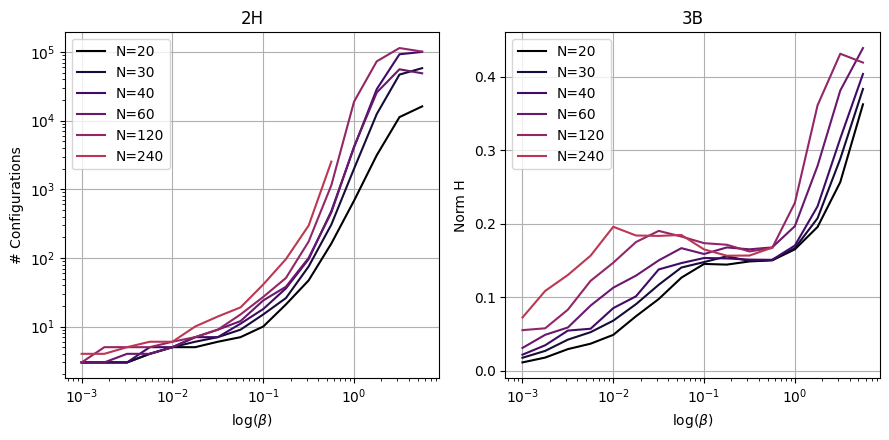

In [73]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(9,4.5))

colors = cm.inferno(np.linspace(0,0.5,len(plot_data.keys())))
for i, (key, table) in enumerate(plot_data.items()):
    table.plot(x='beta', y='# Configs', label=f'N={key}', ax=ax1, color=colors[i])
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_title('2H')
    ax1.set_xlabel(r'log($\beta$)')
    ax1.set_ylabel('# Configurations')
    ax1.grid(which='both', axis='x')
    ax1.grid(which='major', axis='y')
    table.plot(x='beta', y='entropy', label=f'N={key}', ax=ax2, color=colors[i])
    ax2.set_xscale('log')
    ax2.set_title('3B')
    ax2.set_xlabel(r'log($\beta$)')
    ax2.set_ylabel('Norm H')
    ax2.grid(which='both', axis='x')
    ax2.grid(which='major', axis='y')
fig.tight_layout()